# Clinical Trial Eligibility Criteria Analysis

This notebook provides tools to:

- Load and analyze eligibility criteria lengths from all saved trial JSON files
- Visualize the distribution of eligibility criteria lengths
- Find the n trials whose eligibility criteria lengths are closest to the median (the 'most average' trials)

In [15]:
# Import required libraries
import os
import json
import statistics
import matplotlib.pyplot as plt


## Load all trial eligibility criteria lengths

In [17]:
RAW_OUTPUT_DIR = os.path.join("..","output","recent_us","raw")

import concurrent.futures

def get_trial_lengths(raw_dir=RAW_OUTPUT_DIR):
    files = [f for f in os.listdir(raw_dir) if f.endswith('_raw.json')]

    def process_file(file):
        try:
            with open(os.path.join(raw_dir, file), 'r', encoding='utf-8') as f:
                data = json.load(f)
            eligibility = (
                data.get('inclusion_criteria', '') + '\n' +
                data.get('exclusion_criteria', '') + '\n' +
                data.get('miscellaneous_criteria', '')
            ).strip()
            nctid = file[:11]
            return (nctid, len(eligibility))
        except Exception as e:
            print(f'Failed to process {file}: {e}')
            return None

    lengths = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_file, files))
        lengths = [r for r in results if r is not None]

    return lengths

trial_lengths = get_trial_lengths()
print(f"Loaded {len(trial_lengths)} trials.")

Loaded 15601 trials.


## Visualize the distribution of eligibility criteria lengths

Total trials: 15601
Average: 3639.56
Median: 2526.00
Min: 60
Max: 20091
25th percentile: 1128.00
75th percentile: 5341.00


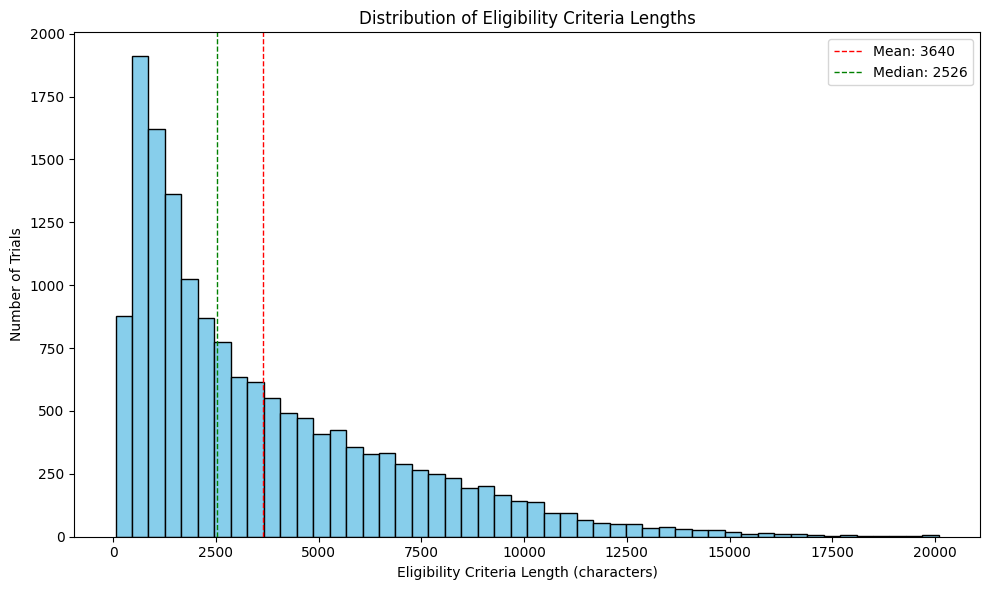

In [18]:
length_values = [l for _, l in trial_lengths]
if length_values:
    avg = sum(length_values) / len(length_values)
    median = statistics.median(length_values)
    p25 = statistics.quantiles(length_values, n=4)[0] if len(length_values) >= 4 else 0
    p75 = statistics.quantiles(length_values, n=4)[2] if len(length_values) >= 4 else 0
    min_len = min(length_values)
    max_len = max(length_values)

    print(f"Total trials: {len(length_values)}")
    print(f"Average: {avg:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Min: {min_len}")
    print(f"Max: {max_len}")
    print(f"25th percentile: {p25:.2f}")
    print(f"75th percentile: {p75:.2f}")

    plt.figure(figsize=(10,6))
    plt.hist(length_values, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(avg, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {avg:.0f}')
    plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median:.0f}')
    plt.title('Distribution of Eligibility Criteria Lengths')
    plt.xlabel('Eligibility Criteria Length (characters)')
    plt.ylabel('Number of Trials')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No trial data found.')

## Find the n trials closest to the median eligibility criteria length

In [19]:
def get_most_median_trials(trial_lengths, n=10):
    if not trial_lengths:
        return []
    median = statistics.median([l for _, l in trial_lengths])
    # Sort by absolute difference from median, then by length for tie-breaking
    sorted_trials = sorted(trial_lengths, key=lambda x: (abs(x[1] - median), x[1]))
    return sorted_trials[:n]

n = 10  # Change as needed
most_median_trials = get_most_median_trials(trial_lengths, n)
print(f"{n} trials closest to the median length:")
for fname, length in most_median_trials:
    print(f"{fname}: {length} characters (diff: {abs(length - statistics.median([l for _, l in trial_lengths])):.2f})")

10 trials closest to the median length:
NCT06806930: 2526 characters (diff: 0.00)
NCT03126019: 2525 characters (diff: 1.00)
NCT03326193: 2524 characters (diff: 2.00)
NCT04177498: 2524 characters (diff: 2.00)
NCT04659174: 2524 characters (diff: 2.00)
NCT03740490: 2528 characters (diff: 2.00)
NCT04378751: 2528 characters (diff: 2.00)
NCT05396885: 2528 characters (diff: 2.00)
NCT02938442: 2523 characters (diff: 3.00)
NCT03899259: 2523 characters (diff: 3.00)


## Find the n trials closest to the mean eligibility criteria length

In [20]:
def get_most_mean_trials(trial_lengths, n=10):
    if not trial_lengths:
        return []
    mean = sum([l for _, l in trial_lengths]) / len(trial_lengths)
    # Sort by absolute difference from mean, then by length for tie-breaking
    sorted_trials = sorted(trial_lengths, key=lambda x: (abs(x[1] - mean), x[1]))
    return sorted_trials[:n]

most_mean_trials = get_most_mean_trials(trial_lengths, n)
print(f"{n} trials closest to the mean length:")
for fname, length in most_mean_trials:
    print(f"{fname}: {length} characters (diff: {abs(length - avg):.2f})")

10 trials closest to the mean length:
NCT03061201: 3640 characters (diff: 0.44)
NCT03880656: 3640 characters (diff: 0.44)
NCT06118502: 3641 characters (diff: 1.44)
NCT04340258: 3642 characters (diff: 2.44)
NCT03682068: 3637 characters (diff: 2.56)
NCT05564377: 3637 characters (diff: 2.56)
NCT04759911: 3643 characters (diff: 3.44)
NCT04515810: 3636 characters (diff: 3.56)
NCT05430035: 3644 characters (diff: 4.44)
NCT06366347: 3644 characters (diff: 4.44)


In [22]:
with open("most_mean_trials.txt", "w") as mean_file:
    for fname, length in most_mean_trials:
        mean_file.write(f"{fname}\n")

# Save most median trials to a file
with open("most_median_trials.txt", "w") as median_file:
    for fname, length in most_median_trials:
        median_file.write(f"{fname}\n")

print("Data saved to most_mean_trials.txt and most_median_trials.txt")

Data saved to most_mean_trials.txt and most_median_trials.txt


# calculate cost

In [25]:
import json

# Path to your token usage file
usage_path = "../output/recent_us/avg10/openai_token_usage_2025-04-25_13-57-11.json"

with open(usage_path, "r") as f:
    usage = json.load(f)

prompt_tokens = usage["prompt_tokens"]
completion_tokens = usage["completion_tokens"]
total_tokens = usage["total_tokens"]

n_trials = 15602
n_sample = 10
scale_factor = n_trials / n_sample

scaled_prompt_tokens = prompt_tokens * scale_factor
scaled_completion_tokens = completion_tokens * scale_factor

models = {
    "OpenAI o3": {"input": 10.00, "cached_input": 2.50, "output": 40.00},
    "OpenAI o4-mini": {"input": 1.10, "cached_input": 0.275, "output": 4.40},
    "GPT-4.1": {"input": 2.00, "cached_input": 0.50, "output": 8.00},
    "GPT-4.1 mini": {"input": 0.40, "cached_input": 0.10, "output": 1.60},
    "gpt-4o": {"input": 2.50, "cached_input": 1.25, "output": 10.00},
}

def cost(tokens, price_per_million):
    return tokens / 1_000_000 * price_per_million

for model, prices in models.items():
    input_cost = cost(scaled_prompt_tokens, prices["input"])
    output_cost = cost(scaled_completion_tokens, prices["output"])
    total_cost = input_cost + output_cost
    print(f"\nModel: {model}")
    print(f"  Input cost: ${input_cost:,.2f}")
    print(f"  Output cost: ${output_cost:,.2f}")
    print(f"  Total cost: ${total_cost:,.2f}")


Model: OpenAI o3
  Input cost: $11,410.54
  Output cost: $3,199.03
  Total cost: $14,609.57

Model: OpenAI o4-mini
  Input cost: $1,255.16
  Output cost: $351.89
  Total cost: $1,607.05

Model: GPT-4.1
  Input cost: $2,282.11
  Output cost: $639.81
  Total cost: $2,921.91

Model: GPT-4.1 mini
  Input cost: $456.42
  Output cost: $127.96
  Total cost: $584.38

Model: gpt-4o
  Input cost: $2,852.63
  Output cost: $799.76
  Total cost: $3,652.39


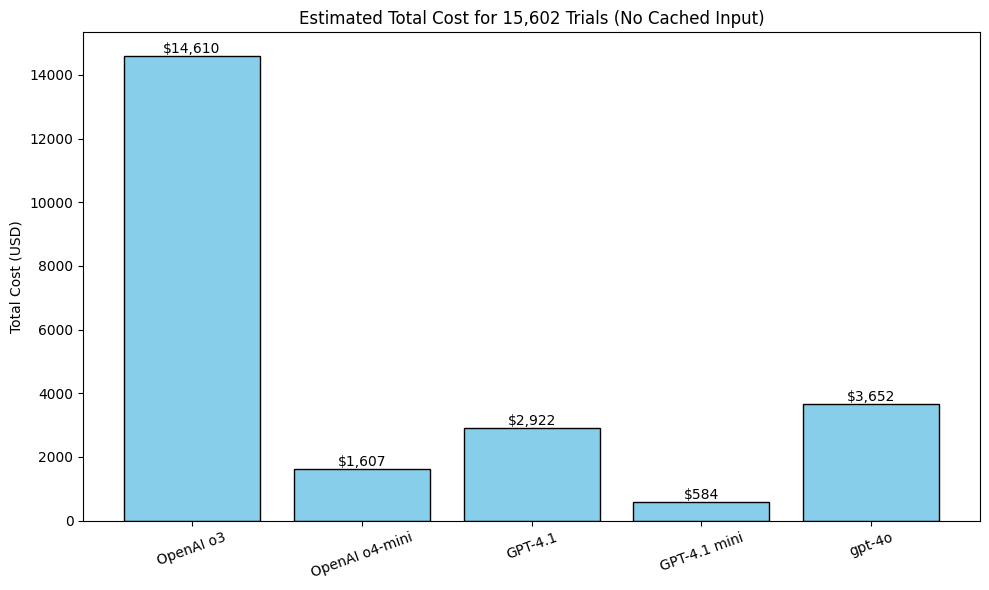

In [ ]:
import matplotlib.pyplot as plt

# Calculate total costs for each model (no cached input)
model_names = []
total_costs = []

for model, prices in models.items():
    input_cost = cost(scaled_prompt_tokens, prices["input"])
    output_cost = cost(scaled_completion_tokens, prices["output"])
    total_cost = input_cost + output_cost
    model_names.append(model)
    total_costs.append(total_cost)

# Plot bar graph
plt.figure(figsize=(10,6))
bars = plt.bar(model_names, total_costs, color='skyblue', edgecolor='black')
plt.ylabel('Total Cost (USD)')
plt.title('Estimated Total Cost for 15,602 Trials')
plt.xticks(rotation=20)
for bar, cost_val in zip(bars, total_costs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${cost_val:,.0f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()